# QA Chat Bot

I will implement chat bot that can answer questions based on a "story" given to the bot. The BaBi dataset by Facebook will be used.

Example of the implementation:

- Story: Jane went to the store. Mike ran to the bedroom.
- Question: Is Mike in the store?
- Answer: No

The overall idea of the model is that it takes a discrete set of inputx $x_{1},...x_{n}$ that are to be stored in the memory, a query $q$, and outputs an answer $a$. Each of the $x, q$, and $a$ contains symbols coming from a dictionary with $V$ words. The model writes all $x$ to the memory up to a fixed buffer size, and then finds continuous representation for the $x$ and $q$.

End to End Network:
- Input Memory Representation
- Ouptup Memory Representation
- Generating Final Prediction

Let's see a diagram representing a single layer, which implements a single memory hop operation:

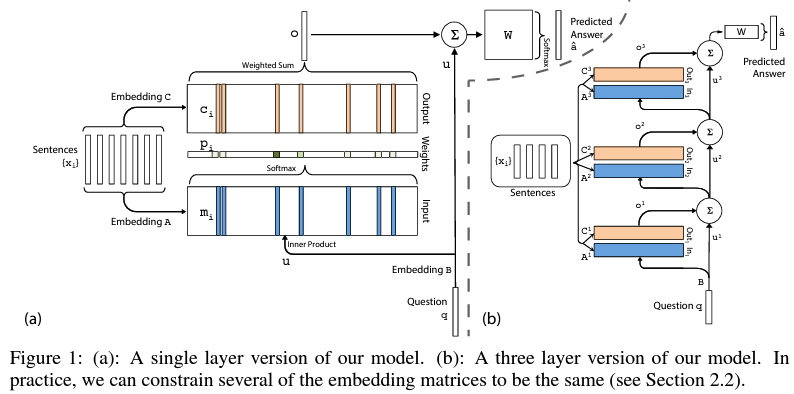

We first start off with the first key component of the single layer, which is the input memory representation. What we expect to recieve is an input set of $x_{1}, x_{2},..., x_{i}$ those are the sentences or stories to be stored in the memory. And we going to convert that entire set of $x$ into memory vectors $m_{i}$ with the dimension $d$. So we can see here 2 types of encoders, annd the bottom one is the $m_{i}$. Then we will use Keras for embedding this to convert sentences and we later on have another embedding and encoder process for $c_{i}$ and we also will recieve that question or query calling $q$, and that's also going to be embedded. We embed that to obtain an internal state $u$. In the bottom of diagram we have question $q$ that is going through an embedding process and then we have the result which is going to be an internal state of this embedding inside the single layer called $u$. In the embedding space, within a single layer we're going to compute the match between $u$ and memory $m_{i}$ by taking inner product followed by a softmax operation. Which looks as following:
<br></br>
<div style="font-size: larger;">
$$p_{i} = Softmax(u^Tm_{i})$$
</div>
<br></br>
<div style="font-size: larger;">

$$Softmax(z_{i}) = \frac{e^{z_{i}}}{\sum_{j} e^{z_{j}}}$$
</div>
<br></br>
We take that question embedded through $Embedding\ B$ then we have $u$ and then we're going to take $u$ transposed. Take the product of that with $m_{i}$ (embedding of the sentences) and thake the $Softmax$ of that. And then you get $p_{i}$. That is input memory representation and then we're need the output memory representation.

So for the output memory representation, each $x_{i}$ has a corresponding output vector $c_{i}$. And this given in the simplest case by another embedding matrix, which is called $Embedding\ c$. Then the response vector from the memory $o$ is a sum over transformed input $c_{i}$, weighted by the probability vector from the input.
<br><br>
$$o = \sum_{i}p_{i}c_{i}$$
<br></br>
And because the function from input to output is smooth, we can then compute gradients and back propagate through this. 

Then th final 3rd step is generating a single final prediction. So in single layer case we're going to have the sum of the output vector $o$ and the input embedding $u$ is passed through a final weight matrix that is labeled as $W$ here. And then $Softmax$ is used to produce the predicted label. 
<br></br>
$$\hat{a} = Softmax(W(o+u))$$
<br></br>
We have the final weight matrix $W$ (of size $V\times d$), and then we have $o+u$ and we pass it through $Softmax$. As the result we get probabilities of the predicted answer. This network is going to produce probability for every single word in the vocabulary. However, we should only expect some relatively high probability on either "yes" or "no".

We can than expand this signle layer into multiple layers using what is mentioned above. We simply going to take the output one single layer and have that be the input for the next layer. The logic remains the same.

In [1]:
import pickle
import numpy as np

We will use pickle to read the data.

In [2]:
with open('train_qa.txt', 'rb') as f:
    train_data = pickle.load(f)

In [3]:
with open('test_qa.txt', 'rb') as f:
    test_data = pickle.load(f)

In [4]:
type(test_data)

list

In [5]:
type(train_data)

list

Let's check out the length of the data:

In [6]:
len(train_data), len(test_data)

(10000, 1000)

The data itself is a list of tuples. We see the story, the question and the answer or a solution.

In [7]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [11]:
' '.join(train_data[0][0]), ' '.join(train_data[0][1])

('Mary moved to the bathroom . Sandra journeyed to the bedroom .',
 'Is Sandra in the hallway ?')

## Building Vocab

So we need to set up a vocabulary of all the words inside our dataset. And to do that we need to make sure that we take not just the training data but also the test data into account.

In [12]:
all_data = test_data + train_data

In [13]:
len(all_data)

11000

I want to use a set in python to add words to my set, in that way it is possible to get a set of all unique words. 

In [14]:
set(train_data[0][0])

{'.',
 'Mary',
 'Sandra',
 'bathroom',
 'bedroom',
 'journeyed',
 'moved',
 'the',
 'to'}

In [16]:
vocab = set()

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [17]:
vocab.add('no')
vocab.add('yes')

As we can see there are not that many words. When we will be doing our own questions and stories we will be limited with the names and words we can use.

In [19]:
print(vocab)

{'office', 'Sandra', 'milk', 'football', 'discarded', 'in', 'yes', 'kitchen', 'no', 'grabbed', 'Is', 'to', 'travelled', 'hallway', 'the', 'journeyed', 'dropped', 'picked', 'up', 'Daniel', 'put', 'moved', 'down', 'bathroom', '.', 'took', 'garden', 'Mary', 'John', 'there', 'back', 'left', 'went', 'bedroom', '?', 'got', 'apple'}


Another thing we need to do for vocab is that we need to add one to it for capturing the length because the later on we're going to use Keras `pad_sequences` and zero is a placeholder for that.

In [20]:
vocab_len = len(vocab) + 1

Now we need to figure out how long is the longest story and how long is the longest question. We will using for `pad_sequences` when we vectorize the data.

In [21]:
# Longest story
all_story_lens = [len(data[0]) for data in all_data]

In [22]:
max_story_len = max(all_story_lens)

In [23]:
max_question_len = max([len(data[1]) for data in all_data])

## Data Preprocessing

In [27]:
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

Let's create an integer encoding for the sequence of words.

In [28]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

Let's take a look at `tokenizer` object. We can also see a word index. And what is important, it was automatically lowercased.

In [29]:
print(tokenizer.word_index)

{'office': 1, 'sandra': 2, 'milk': 3, 'football': 4, 'discarded': 5, 'in': 6, 'yes': 7, 'kitchen': 8, 'no': 9, 'grabbed': 10, 'is': 11, 'to': 12, 'travelled': 13, 'hallway': 14, 'the': 15, 'journeyed': 16, 'dropped': 17, 'picked': 18, 'up': 19, 'daniel': 20, 'put': 21, 'moved': 22, 'down': 23, 'bathroom': 24, '.': 25, 'took': 26, 'garden': 27, 'mary': 28, 'john': 29, 'there': 30, 'back': 31, 'left': 32, 'went': 33, 'bedroom': 34, '?': 35, 'got': 36, 'apple': 37}


Let's perform the same type of tokenization but for story, questions and answers.

In [30]:
train_story_text = []
train_question_test = []
train_answers = []

for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_test.append(question)
    train_answers.append(answer)

In [31]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [32]:
def vectorize_stories(data, 
                      word_index=tokenizer.word_index, 
                      max_strory_len=max_story_len, 
                      max_question_len=max_question_len):
    # Stories
    X = []
    # Questions
    Xq = []
    # Correct answers
    Y = []
    
    for story, query, answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]
        y = np.zeros(len(word_index)+1)
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X,maxlen=max_story_len), pad_sequences(Xq,maxlen=max_question_len), np.array(Y))

In [33]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [34]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

What we can notice is that we have their word index position along with their word index.

In [35]:
inputs_test

array([[ 0,  0,  0, ..., 15, 34, 25],
       [ 0,  0,  0, ..., 15, 27, 25],
       [ 0,  0,  0, ..., 15, 27, 25],
       ...,
       [ 0,  0,  0, ..., 15, 37, 25],
       [ 0,  0,  0, ..., 15, 27, 25],
       [ 0,  0,  0, ..., 37, 30, 25]])

In [37]:
tokenizer.word_index['yes'], tokenizer.word_index['no']

(7, 9)

There are 497 ones at the index location 7. And at index location 9 there are 504 the word index for "no".

In [38]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0., 497.,   0., 503.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

## Building Network

In [40]:
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

Frist that we need to do is to hold up a placeholder. From the paper we know we technically have 2 inputs. We have not just these stories, but we also have the questions. So we have the story which encoder needs to understand, then a separate question and then we have to link them together in order to provide a label "yes" or "no". We want to create placeholders using input. So the `Input` function of Kera is used to instantiate a Keras tensor. 

In the `input_sequence` for the shape I added a coma. Since it is known as a placeholder this going to be able to take in the inputs of the stories with a shape of the max story length and then a batch size. And how Keras work for the batch size, since we technically want to be able to edit our batch size that we don't know yet, we just leave it blank by adding in a comma.

In [41]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

Now it's time to create input encoders. The first thing that is needed to be done is to define our vocabulary size and it was previously defined as `vocab_len`

In [42]:
# Previously called vocab_len
vocab_size = len(vocab) + 1

Now let's create input $Encoder\ m$. So this input gets embedded for a sequence of vectors. 

In [44]:
input_encoder_m = Sequential()

# Emabedding layer
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))

# Dropout layer to switch of a percentage of layers in the net randomly as the training goes
input_encoder_m.add(Dropout(0.35))

# OUTPUT
# The output is the (samples, story_max_len, embedding_dimention)

Let's create $Encoder\ c$.

In [45]:
input_encoder_c = Sequential()

# Emabedding layer
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))

# Dropout layer to switch of a percentage of layers in the net randomly as the training goes
input_encoder_c.add(Dropout(0.3))

# OUTPUT
# The output is the (samples, story_max_len, max_qestion_len)

Now the question encoder.

In [48]:
question_encoder = Sequential()

question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))

question_encoder.add(Dropout(0.3))

# OUTPUT
# (samples, query_maxlen, embedding_dim)

We have already placeholsers for sequence and question. So we want to pass in these inputs into our encoders, the input $Encoder\ m$, the input $Encoder\ c$ and $Question\ Encoder$.

In [50]:
# ENCODED <-- ENCODER(INPUT)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

Now wer need to use a dot product to compute the match between the first input vector sequence and the query.

In [51]:
match = dot([input_encoded_m, question_encoded], axes=(2,2))
match = Activation('softmax')(match)

Now we want to add this match matrix with the second input vector sequence. Essentially we converting it to have an output samples by query maxt length by story max length.

In [52]:
response = add([match, input_encoded_c])
response = Permute((2,1))(response)

So once we have our response we can concatentat the match matrix with the question vector sequence.

In [53]:
answer = concatenate([response, question_encoded])

In [54]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

Now we have our answer tensor and then we're just going to reduce it with a recurrent neural network.

In [55]:
answer = LSTM(32)(answer)

In [56]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

So what we need to do is then output a probability distribution over the vocabulary because we will see a bunch of zeros except some probability on "yes" and some probability on "no". And we will pas that in through a $Softmax$ in order to turn into a 0 or 1. 

In [57]:
answer = Activation('softmax')(answer)

## Model Building

In [58]:
model = Model([input_sequence, question], answer)

In [59]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_5 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

## Fit and train the model

In [62]:
history = model.fit([inputs_train, queries_train], answers_train, 
                    batch_size=32, epochs=100, validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/100
313/313 [==============================] - 8s 17ms/step - loss: 0.9312 - accuracy: 0.4943 - val_loss: 0.6980 - val_accuracy: 0.5030
Epoch 2/100
313/313 [==============================] - 5s 14ms/step - loss: 0.7083 - accuracy: 0.4997 - val_loss: 0.6935 - val_accuracy: 0.5030
Epoch 3/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6980 - accuracy: 0.5075 - val_loss: 0.6964 - val_accuracy: 0.5030
Epoch 4/100
313/313 [==============================] - 4s 14ms/step - loss: 0.6976 - accuracy: 0.4963 - val_loss: 0.6934 - val_accuracy: 0.4970
Epoch 5/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6960 - accuracy: 0.5049 - val_loss: 0.6936 - val_accuracy: 0.4970
Epoch 6/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6956 - accuracy: 0.4977 - val_loss: 0.6935 - val_accuracy: 0.4970
Epoch 7/100
313/313 [==============================] - 5s 14ms/step - loss: 0.6958 - accuracy: 0.4957 - val_loss: 0.6932 - val_accuracy:

313/313 [==============================] - 4s 13ms/step - loss: 0.6945 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 58/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6948 - accuracy: 0.4983 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 59/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6946 - accuracy: 0.5006 - val_loss: 0.7004 - val_accuracy: 0.4970
Epoch 60/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6943 - accuracy: 0.5039 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 61/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6951 - accuracy: 0.4902 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 62/100
313/313 [==============================] - 4s 14ms/step - loss: 0.6944 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 63/100
313/313 [==============================] - 4s 14ms/step - loss: 0.6951 - accuracy: 0.4967 - val_loss: 0.6935 - val_accuracy: 0.497

Let's plot out training history.

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

<built-in method keys of dict object at 0x000001FB4FB37E58>


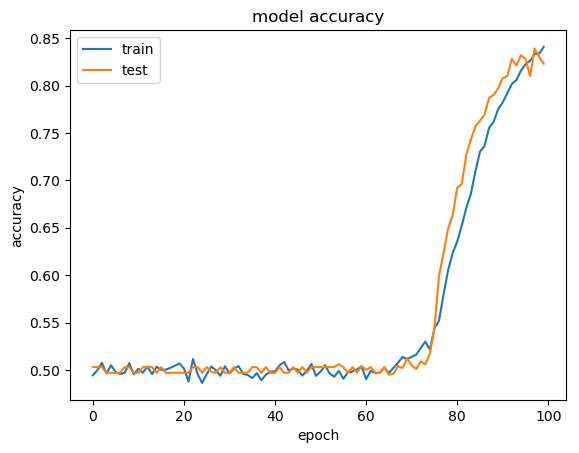

In [69]:
print(history.history.keys)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
model.save('chat-bot.h5')

## Model Evaluation

We're going to predict results for the input test and querys test.

In [71]:
pred_results = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 1s 3ms/step


Let's generate prediction out of an actual model.

In [72]:
pred_results.shape

(1000, 38)

In [73]:
val_max = np.argmax(pred_results[0])

In [74]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

This is the correct answer. Let's prove it a little bit down below.

In [75]:
k

'no'

In [77]:
print(test_data[0][0], test_data[0][1], test_data[0][2])

['Mary', 'got', 'the', 'milk', 'there', '.', 'John', 'moved', 'to', 'the', 'bedroom', '.'] ['Is', 'John', 'in', 'the', 'kitchen', '?'] no


We can also check how sure it is of it.

In [78]:
pred_results[0][val_max]

0.8739374

Let's write our own stroies and questions and run them through the model.

In [79]:
my_story = 'John left the kitchen . Sandra dropped the football in the garden . '

In [80]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [81]:
my_question = 'Is the football in the garden ?'

In [82]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [83]:
mydata = [(my_story.split(), my_question.split(), 'yes')]

In [84]:
my_story, my_ques, my_ans = vectorize_stories(mydata)

In [86]:
pred_results = model.predict(([my_story, my_ques]))

1/1 [==============================] - 0s 22ms/step


In [87]:
val_max = np.argmax(pred_results[0])

In [88]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [89]:
k

'yes'

In [90]:
pred_results[0][val_max]

0.9301559